In [1]:
import json
from pathlib import Path

In [2]:
def read_squad(path):
    path = Path(path)
    with open(path, 'rb') as f:
        squad_dict = json.load(f)
    
    contexts = []
    questions = []
    answers = []

    for group in squad_dict['data']:
        for passage in group['paragraphs']:
            context = passage['context']
            for qa in passage['qas']:
                question = qa['question']
                for answer in qa['answers']:
                    contexts.append(context)
                    questions.append(question)
                    answers.append(answer)
    
    return contexts, questions, answers

In [3]:
train_contexts, train_questions, train_answers = read_squad("squad/train-v2.0.json")
valid_contexts, valid_questions, valid_answers = read_squad("squad/dev-v2.0.json")

In [4]:
def add_end_idx(answers, contexts):
    for answer, context in zip(answers, contexts):
        gold_text = answer['text']
        start_idx = answer['answer_start']
        end_idx = start_idx + len(gold_text)

        # sometimes squad answers are off by a character or two -- fix this
        if context[start_idx:end_idx] == gold_text:
            answer['answer_end'] = end_idx
        elif context[start_idx-1:end_idx-1] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 1
        elif context[start_idx-2:end_idx-2] == gold_text:
            answer['answer_start'] = start_idx - 1
            answer['answer_end'] = end_idx - 2

In [5]:
add_end_idx(train_answers, train_contexts)
add_end_idx(valid_answers, valid_contexts)

In [6]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
valid_encodings = tokenizer(valid_contexts, valid_questions, truncation=True, padding=True)

In [7]:
train_encodings[0]
# Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
# truncation=True, padding=True -> padding to max_length!

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [8]:
type(train_encodings[0])
# tokenizers.Encoding

tokenizers.Encoding

In [9]:
type(train_encodings)
# transformers.tokenization_utils_base.BatchEncoding

transformers.tokenization_utils_base.BatchEncoding

In [10]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []

    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))
        # When using huggingface's Fast Tokenizers, we can use the built-in `char_to_token()` method

        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    # currently, Encoding has attributes of [ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing]
    # now, it adds start_positions and end_positions in addition to the attributes above

In [11]:
add_token_positions(train_encodings, train_answers)
add_token_positions(valid_encodings, valid_answers)

In [12]:
train_encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [13]:
import torch
from torch.utils.data import Dataset

class SquadDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # return as a dict of [input_ids, attention_mask, start_positions, end_positions]
    
    def __len__(self):
        return len(self.encodings.input_ids)


In [14]:
train_dataset = SquadDataset(train_encodings)
valid_dataset = SquadDataset(valid_encodings)

In [15]:
train_dataset[0].keys()

dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions'])

In [16]:
for key, value in train_dataset[0].items():
    print(key, value.shape)
    
    # input_ids torch.Size([512])
    # attention_mask torch.Size([512])
    # start_positions torch.Size([])
    # end_positions torch.Size([])

input_ids torch.Size([512])
attention_mask torch.Size([512])
start_positions torch.Size([])
end_positions torch.Size([])


In [17]:
from transformers import AutoConfig, DistilBertForQuestionAnswering

config = AutoConfig.from_pretrained("distilbert-base-uncased")
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

In [18]:
import torch
import torch.nn as nn

class CustomHeadRNN(nn.Module):
    def __init__(self, config):
        super(CustomHeadRNN, self).__init__()
        
        self.p1_lstm = nn.LSTM(config.hidden_size, config.hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.p1_drop = nn.Dropout(p=config.qa_dropout)
        self.p1_fc   = nn.Linear(2*config.hidden_size, 1)

        self.p2_lstm = nn.LSTM(config.hidden_size, config.hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.p2_drop = nn.Dropout(p=config.qa_dropout)
        self.p2_fc   = nn.Linear(2*config.hidden_size, 1)

    def forward(self, hidden_states):
        p1_out, (h_p1, c_p1) = self.p1_lstm(hidden_states)
        p1_out = self.p1_drop(p1_out)
        p1_out = self.p1_fc(p1_out)

        p2_out, (h_p2, c_p2) = self.p2_lstm(hidden_states, (h_p1, c_p1))
        p2_out = self.p2_drop(p2_out)
        p2_out = self.p2_fc(p2_out)

        return torch.cat([p1_out, p2_out], dim=-1)


In [19]:
model.qa_outputs = CustomHeadRNN(config)
# insert custom-defined head

In [20]:
example = train_dataset[0]

input_ids = example['input_ids'].unsqueeze(0)
attention_mask = example['attention_mask'].unsqueeze(0)

output = model.distilbert(input_ids=input_ids, attention_mask=attention_mask)
last_hidden_state = output['last_hidden_state']

last_hidden_state.shape
# [batch_size, model_max_length, hidden_size]

torch.Size([1, 512, 768])

In [21]:
qa_output = model.qa_outputs(last_hidden_state)
qa_output.shape
# [batch_size, model_max_length, positions]

torch.Size([1, 512, 2])

In [22]:
from torch.utils.data import DataLoader
from transformers import AdamW
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

In [23]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

optim = AdamW(model.parameters(), lr=5e-5)

In [24]:
from transformers.trainer_utils import EvalPrediction
from datasets import load_metric

metric = load_metric("squad")

def compute_metrics(pred: EvalPrediction):
    print(pred.predictions)
    print(pred.label_ids)
    return metric.compute(predictions=pred.predictions, references=pred.label_ids)

In [25]:
def compute_exact_match(start_positions, end_positions, start_logits, end_logits):
    start_pred = torch.argmax(start_logits)
    end_pred = torch.argmax(end_logits)

    start_match = start_pred == start_positions
    end_match = end_pred == end_positions
    exact_match = torch.all(torch.cat([start_match.unsqueeze(1), end_match.unsqueeze(1)], dim=1), dim=1)

    return torch.mean(exact_match.float())


In [46]:
# 이 셀은 실행 안해도 됩니다!
# 아래에 있는 Trainer를 실행해주세요!

epochs = 5
train_losses = []
train_ems = []
val_losses = []
val_ems = []

for epoch in range(epochs):

    model.train()

    for idx, batch in enumerate(train_loader):
        optim.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        outputs = model(
            input_ids, 
            attention_mask=attention_mask, 
            start_positions=start_positions,
            end_positions=end_positions,
        )

        loss = outputs.loss

        start_logits = outputs.start_logits
        end_logits = outputs.end_logits
        em_score = compute_exact_match(start_positions, end_positions, start_logits, end_logits)

        loss.backward()
        optim.step()

        train_losses.append(loss.item())
        train_ems.append(em_score.item())

    print("="*10 + " epoch {} ".format(epoch) + "="*10)
    print("train_loss:", np.mean(train_losses[-idx:]))
    print("train_ems:", np.mean(train_ems[-idx:]))
    print()

    model.eval()

    with torch.no_grad():
        for idx, batch in enumerate(val_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_positions'].to(device)
            end_positions = batch['end_positions'].to(device)

            outputs = model(
                input_ids, 
                attention_mask=attention_mask, 
                start_positions=start_positions,
                end_positions=end_positions,
            )

            loss = outputs.loss
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

            em_score = compute_exact_match(start_positions, end_positions, start_logits, end_logits)

            val_losses.append(loss.item())
            val_ems.append(em_score.item())

    print("valid_loss:", np.mean(val_losses[-idx:]))
    print("valid_ems:", np.mean(val_ems[-idx:]))
    print()


========== epoch 0 ==========
train_loss: 1.541540998464311
train_ems: 0.0029372465904902324

valid_loss: 1.2990654921394182
valid_ems: 0.0284897476340694



KeyboardInterrupt: 

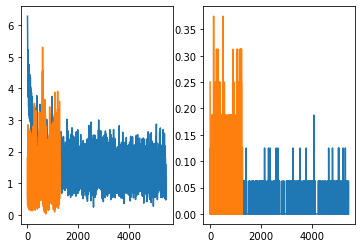

In [47]:
# 마찬가지로 이 셀은 실행 안해도 됩니다!
# 아래에 있는 Trainer를 실행해주세요!

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)

ax[0].plot(train_losses)
ax[0].plot(val_losses)

ax[1].plot(train_ems)
ax[1].plot(val_ems)

plt.show()

In [26]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./saved',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    do_train=True,
    do_eval=True
)

In [27]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [28]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: this-is-real (use `wandb login --relogin` to force relogin)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: wandb version 0.12.5 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss
100,5.868300
200,4.551600
300,3.553400
400,2.847900
500,2.485300
600,2.094700
